# TP2 : Premier Réseau de neurones artificiels
## **Réalisé par Hugo et Teddy**

Ce note book propose plusieurs modèles avec une analyse de leurs performances 

## 1 IMPORT ET SETTINGS



In [1]:
# Tous les paquets sont déjà installés dans l’environnement conda
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import cv2
import warnings

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix,classification_report
from skimage import exposure
import zipfile
from PIL import Image
import datetime

%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPool2D, Dense, Flatten, Dropout, Activation

print(tf.__version__)


2025-12-07 17:20:33.497936: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


## 2. DATASET EXPLORATION 

remarque : modifiez les chemins vers les fichiers et les dossiers pour correspondre à l'organisation de votre Drive

In [2]:

#ds_file_zip = "/content/drive/MyDrive/SE-5104A/tp/archive.zip"
# !unzip fichier_à_décompresser -d dossier dans lequel il faut décompresser les données
#!unzip "/content/drive/MyDrive/SE-5104A/tp/archive.zip" -d "/content/drive/MyDrive/SE-5104A/tp/dataset/"

path_ds = '/Users/hugo/Desktop/TPs_IA_embarquée/TP2'
print(os.listdir(path_ds))
print( os.listdir(os.path.join(path_ds,'train')))

['test', 'meta', 'Complet.py', 'TP2_RoadSignNetwork.ipynb', 'FINAL.ipynb', 'logs', '33.png', 'train', '.git', '.conda', 'image.png', 'Rapport']
['32', '35', '34', '33', '20', '18', '27', '9', '0', '11', '7', '29', '16', '42', '6', '28', '17', '1', '10', '19', '26', '8', '21', '38', '36', '31', '30', '37', '39', '41', '24', '23', '4', '15', '3', '12', '40', '2', '13', '5', '14', '22', '25']


# 3. DATASET LOADING AND PREPROCESSING

Maintenant, on vas préparer les données pour l'utilisation pour l'entrainement et on en profite pour regarder quelques images dans le dataset. Les étapes sont les suivantes


1.   Lire les images dans les dossiers du répértoire dataset (0,1,2..), ces sont les classes à reconnaitre
2.   Réunir dans deux np.array distints
    - les images redimensionnées à 30x30
    - les numéros des labels correspondants à chaque image

3. Dans l'étape d'amélioration des résultats, vous devez égaliser l'histogramme des images (enlever les effets d'un mauvais éclairage)
 image = exposure.equalize_adapthist(image, clip_limit=0.1)

In [3]:
# Setting variables for later use
data = [] # ici je vais stocker les images
labels = [] # ici les labels
classes = 43 # c'est le nombre de classes dans le dataset
n_learned_classes = classes # alias pour manipuler plus facielement le nombre de classes


# Retrieving the images and their labels
for i in range(n_learned_classes): # Boucle sur les classes
    path = os.path.join(path_ds,'train',str(i))
    images = os.listdir(path)
    print ('Classe : ' + str(i), len(images)) # on affiche le nombre d'images par classes pour vérifier la cohérence du dataset

    for a in images: # Boucle sur les images
        try:
            image = Image.open(path + '/' + a  ) # on ouvre
            image = image.resize((30,30)) # On redimension l'image en 30x30 pixels
            # ces deux lignes si-dessous, on va les utiliser plus tard
            image = np.array(image) # on convertit en tableau numpy HxLxC donc 30x30x3
            # placer ici une équalisation de l'histogramme de l'image
            image =  exposure.equalize_adapthist(image, clip_limit=0.1)# On vient rendre les images plus lisibles
            data.append(image)# On ajoute l'image dans la liste data
            labels.append(i)#on ajoute le label dans la liste labels
        except:
            print("Error loading image") # Si une image ne peut pas être chargée, message d'erreur


# Converting lists into numpy arrays
data = np.array(data)#On convertit la liste en tableau numpy car mieux pour ccn
labels = np.array(labels)#idem
print(data.size)
print(labels.size)

Classe : 0 210
Classe : 1 66
Classe : 2 453
Classe : 3 644
Classe : 4 809
Classe : 5 868
Classe : 6 420
Classe : 7 638
Classe : 8 622
Classe : 9 690
Classe : 10 833
Classe : 11 605
Classe : 12 503
Classe : 13 560
Classe : 14 780
Classe : 15 630
Classe : 16 420
Classe : 17 916
Classe : 18 522
Classe : 19 210
Classe : 20 360
Classe : 21 330
Classe : 22 390
Classe : 23 510
Classe : 24 270
Classe : 25 688
Classe : 26 600
Classe : 27 240
Classe : 28 540
Classe : 29 270
Classe : 30 450
Classe : 31 780
Classe : 32 240
Classe : 33 689
Classe : 34 420
Classe : 35 518
Classe : 36 390
Classe : 37 210
Classe : 38 921
Classe : 39 300
Classe : 40 360
Classe : 41 240
Classe : 42 240
57658500
21355


Répartition des classes dans le dataset juste pour voir si il y a des classes sous représentées


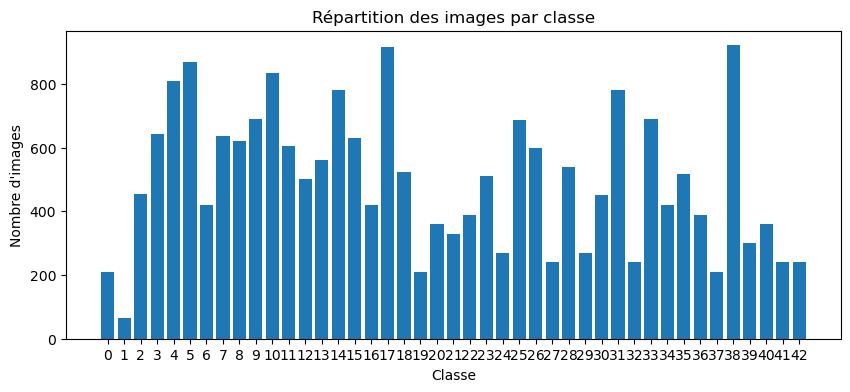

In [4]:
unique, counts = np.unique(labels, return_counts=True)

plt.figure(figsize=(10,4))
plt.bar(unique, counts)
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe")
plt.xticks(unique)
plt.show()

On regarde à quoi cela ressemble. Par exemple :

In [ ]:
for j in  range(800,805):
  plt.figure()
  plt.imshow(data[j,:,:,:])

préparer les ensembles de données bien formatées pour l'apprentissage -> vérifions les dimensions, l'encodage des classes (one-hot) et puis coupons le dataset en partie : training et validation

In [5]:
# Checking data shape
print(data.shape, labels.shape)

# Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Displaying the shape after the split
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

train_ds = image_dataset_from_directory(
    "train",
    image_size=(30, 30),
    batch_size=32,
    shuffle=True
)

(21355, 30, 30, 3) (21355,)
(17084, 30, 30, 3) (4271, 30, 30, 3) (17084,) (4271,)
Found 21355 files belonging to 43 classes.


2025-12-07 17:25:36.212341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 4. Les différents modèles

On est prêt, on peut construire nos premiers modèles de réseaux de neurons artificiels. On va commencer par combiner les couches pleinement connectées (on n'a pas travaillé d'autres en classes)

- V1 : 2 couches pleinement connectées 
- V2 : 3 couches au minimum pleinement connectées 
- V3 : 2 couches pleinement connectées précdées par une couche convolutive (placée devant couche flatten).
- V4 (optionnelle) modèle personnel 

## **modèle 1**

In [26]:
from tensorflow import keras


# Building the model V1 (MLP sans convolution)
model_v1 = Sequential()

# On garde la même shape d'entrée (H, W, 3)
model_v1.add(keras.Input(shape=X_train.shape[1:]))

# On aplatit l'image en vecteur
model_v1.add(Flatten())

# 2 couches pleinement connectées
model_v1.add(Dense(512, activation='relu'))   # 1ère couche Dense
model_v1.add(Dense(256, activation='relu'))   # 2ème couche Dense

# Couche de sortie (43 classes GTSRB)
model_v1.add(Dense(43, activation='softmax'))

# Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v1.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 2700)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1382912   
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 43)                11051     
                                                                 
Total params: 1,525,291
Trainable params: 1,525,291
Non-trainable params: 0
_________________________________________________________________


Entrainement du réseau et évaluations des performances

In [28]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_v1.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 12s 9ms/step - loss: 1.8734 - accuracy: 0.5457 - val_loss: 0.8996 - val_accuracy: 0.7940
Epoch 2/50
1068/1068 [==============================] - 8s 8ms/step - loss: 0.6645 - accuracy: 0.8428 - val_loss: 0.5300 - val_accuracy: 0.8715
Epoch 3/50
1068/1068 [==============================] - 8s 8ms/step - loss: 0.4094 - accuracy: 0.9035 - val_loss: 0.3702 - val_accuracy: 0.9094
Epoch 4/50
1068/1068 [==============================] - 8s 7ms/step - loss: 0.2984 - accuracy: 0.9289 - val_loss: 0.3400 - val_accuracy: 0.9131
Epoch 5/50
1068/1068 [==============================] - 8s 7ms/step - loss: 0.2324 - accuracy: 0.9442 - val_loss: 0.2833 - val_accuracy: 0.9162
Epoch 6/50
1068/1068 [==============================] - 8s 7ms/step - loss: 0.1873 - accuracy: 0.9545 - val_loss: 0.2454 - val_accuracy: 0.9351
Epoch 7/50
1068/1068 [==============================] - 9s 9ms/step - loss: 0.1576 - accuracy: 0.9621 - val_loss: 0.2719 - val_accuracy

test du modèle


1/1 [==============================] - 0s 343ms/step


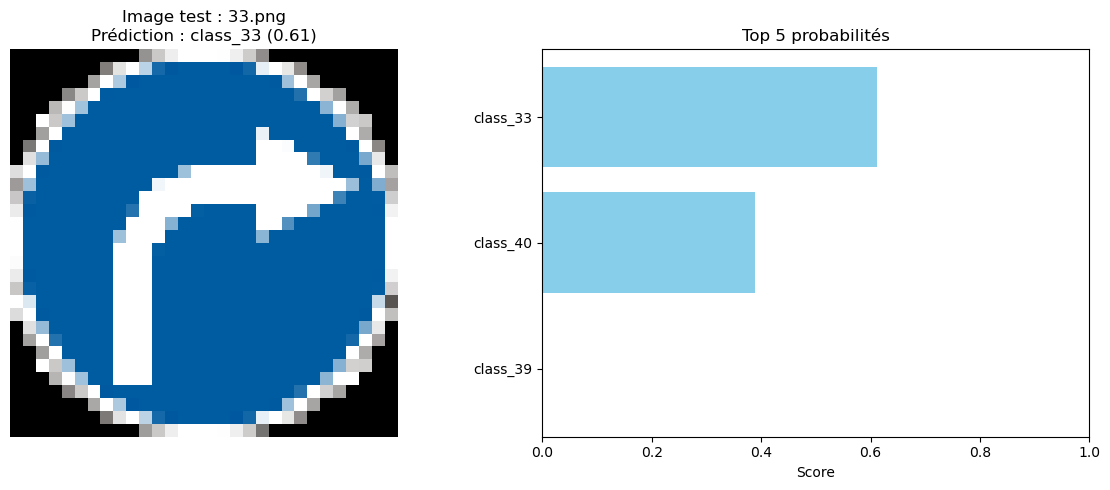


Top prédictions :
class_33             -> 0.612
class_40             -> 0.388
class_39             -> 0.000


In [31]:
# Params
IMG_PATH = "33.png"#chemin image test
IMG_SIZE = (X_train.shape[1],X_train.shape[2])# taille d'entrée du modèle
N_CLASSES = 43#nombre de classes du dataset

# Names des classes
class_names = [f"class_{i}" for i in range(N_CLASSES)]

# Charger et préparer l'image
img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

# Prédiction
preds = model_v1.predict(x)[0]
top_k = 3 # top 3 classes les plus probables
top_idx = np.argsort(preds)[-top_k:][::-1]

# affichage
plt.figure(figsize=(12,5))

# Image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

# Barres de probas
plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

# Impression console
print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


## **modèle 2**

In [32]:
from tensorflow import keras

model_v2 = Sequential()

# Entrée : même shape que X_train (H, W, 3)
model_v2.add(keras.Input(shape=X_train.shape[1:]))

# Aplatissement de l'image
model_v2.add(Flatten())

# 3 couches pleinement connectées
model_v2.add(Dense(512, activation='relu'))   # 1ère Dense
model_v2.add(Dense(256, activation='relu'))   # 2ème Dense
model_v2.add(Dense(128, activation='relu'))   # 3ème Dense

# Couche finale pour 43 classes
model_v2.add(Dense(43, activation='softmax'))

# Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v2.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v2.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 2700)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               1382912   
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 43)                5547      
                                                                 
Total params: 1,552,683
Trainable params: 1,552,683
Non-trainable params: 0
_________________________________________________________________


In [35]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history=model_v2.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 10s 9ms/step - loss: 0.0356 - accuracy: 0.9898 - val_loss: 0.1303 - val_accuracy: 0.9675
Epoch 2/50
1068/1068 [==============================] - 9s 8ms/step - loss: 0.0100 - accuracy: 0.9972 - val_loss: 0.1315 - val_accuracy: 0.9672
Epoch 3/50
1068/1068 [==============================] - 8s 8ms/step - loss: 5.4215e-04 - accuracy: 1.0000 - val_loss: 0.1348 - val_accuracy: 0.9693
Epoch 4/50
1068/1068 [==============================] - 9s 9ms/step - loss: 0.0271 - accuracy: 0.9926 - val_loss: 0.1367 - val_accuracy: 0.9672
Epoch 5/50
1068/1068 [==============================] - 9s 8ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1310 - val_accuracy: 0.9714
Epoch 6/50
1068/1068 [==============================] - 10s 10ms/step - loss: 4.0805e-04 - accuracy: 1.0000 - val_loss: 0.1295 - val_accuracy: 0.9724
Epoch 7/50
1068/1068 [==============================] - 10s 10ms/step - loss: 2.1827e-04 - accuracy: 1.0000 - val_loss: 0.138

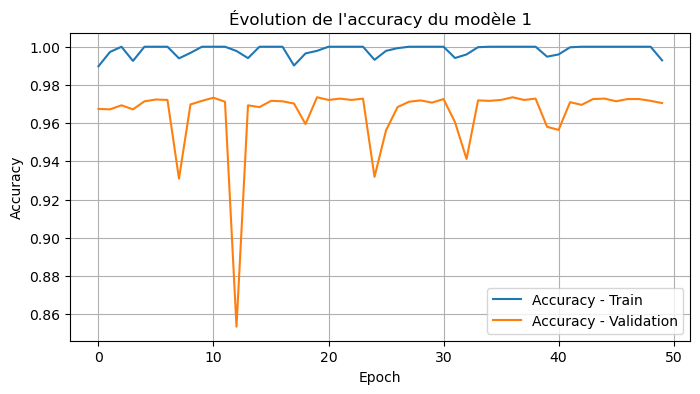

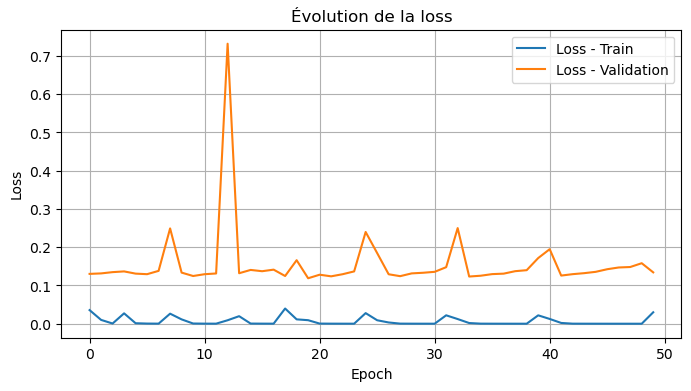

In [ ]:
# Visualisation des courbes d'apprentissage

# Accuracy
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Accuracy - Train')
plt.plot(history.history['val_accuracy'], label='Accuracy - Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Évolution de l'accuracy du modèle 1")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Loss - Train')
plt.plot(history.history['val_loss'], label='Loss - Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss du modèle 1")
plt.legend()
plt.grid(True)
plt.show()

134/134 [==============================] - 1s 7ms/step


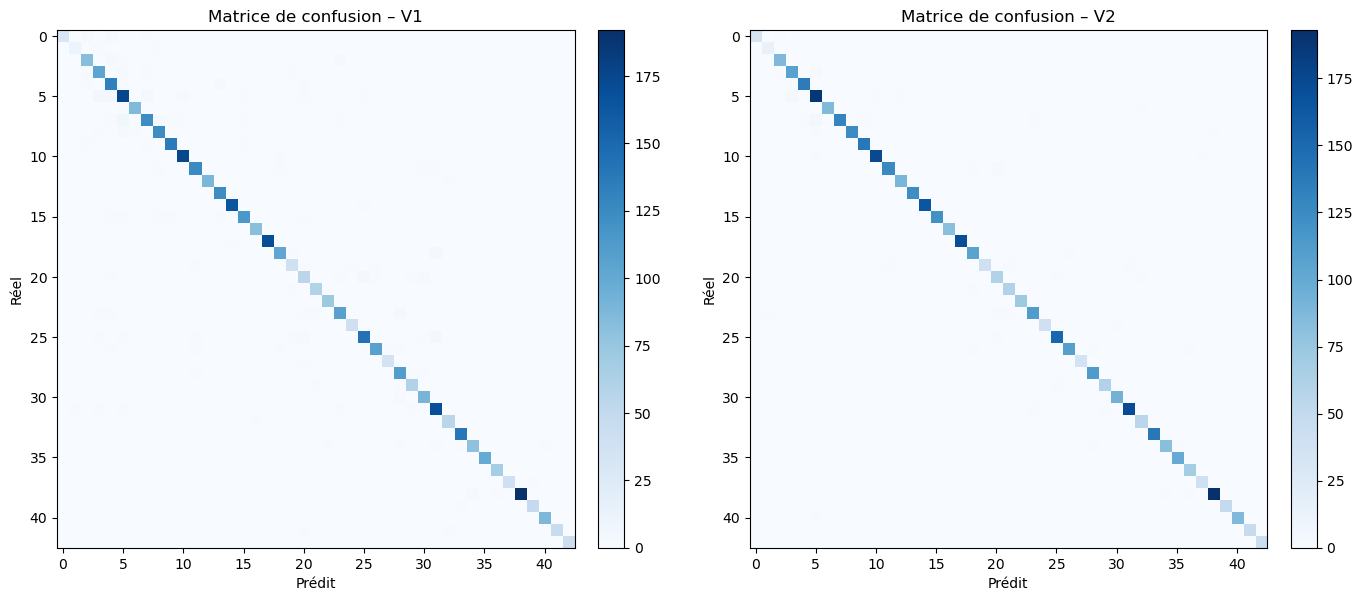

In [ ]:
# Params
IMG_PATH = "33.png"#chemin image test
IMG_SIZE = (X_train.shape[1],X_train.shape[2])# taille d'entrée du modèle
N_CLASSES = 43#nombre de classes du dataset

# Names des classes
class_names = [f"class_{i}" for i in range(N_CLASSES)]

# Charger et préparer l'image
img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

# Prédiction
preds = model_v2.predict(x)[0]
top_k = 3 # top 3 classes les plus probables
top_idx = np.argsort(preds)[-top_k:][::-1]

# affichage
plt.figure(figsize=(12,5))

# Image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

# Barres de probas
plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

# Impression console
print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


## **Modèle 3**

In [11]:
from tensorflow import keras

#  1 conv + Flatten + 2 Dense


model_v3 = Sequential()

model_v3.add(keras.Input(shape=X_train.shape[1:]))

# Couche convolutive
model_v3.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))

# MaxPooling
model_v3.add(MaxPool2D(pool_size=(2, 2)))

# Passage en vecteur
model_v3.add(Flatten())

# 1ère couche pleinement connectée
model_v3.add(Dense(256, activation='relu'))

# 2ème couche pleinement connectée = couche de classification
model_v3.add(Dense(43, activation='softmax'))   # 43 classes

# Compilation
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v3.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Affichage du modèle
model_v3.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 5408)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1384704   
                                                                 
 dense_4 (Dense)             (None, 43)                11051     
                                                                 
Total params: 1,398,187
Trainable params: 1,398,187
Non-trainable params: 0
____________________________________________

In [12]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_v3.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 13s 12ms/step - loss: 1.7580 - accuracy: 0.5880 - val_loss: 0.7003 - val_accuracy: 0.8272
Epoch 2/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.4605 - accuracy: 0.8938 - val_loss: 0.3715 - val_accuracy: 0.9068
Epoch 3/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.2571 - accuracy: 0.9416 - val_loss: 0.2409 - val_accuracy: 0.9417
Epoch 4/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.1641 - accuracy: 0.9659 - val_loss: 0.1691 - val_accuracy: 0.9572
Epoch 5/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.1142 - accuracy: 0.9764 - val_loss: 0.1494 - val_accuracy: 0.9618
Epoch 6/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.0795 - accuracy: 0.9846 - val_loss: 0.1220 - val_accuracy: 0.9661
Epoch 7/50
1068/1068 [==============================] - 12s 11ms/step - loss: 0.0549 - accuracy: 0.9898 - val_loss: 0.0998 -

1/1 [==============================] - 0s 172ms/step


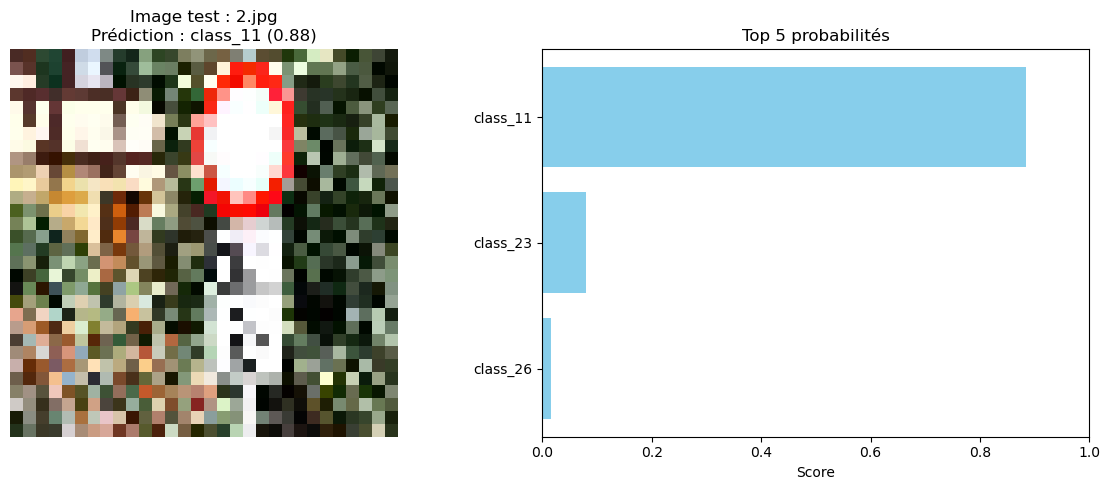


Top prédictions :
class_11             -> 0.884
class_23             -> 0.081
class_26             -> 0.016


In [23]:
# Params
IMG_PATH = "2.jpg"#chemin image test
IMG_SIZE = (X_train.shape[1],X_train.shape[2])# taille d'entrée du modèle
N_CLASSES = 43#nombre de classes du dataset

# Names des classes
class_names = [f"class_{i}" for i in range(N_CLASSES)]

# Charger et préparer l'image
img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

# Prédiction
preds = model_v3.predict(x)[0]
top_k = 3 # top 3 classes les plus probables
top_idx = np.argsort(preds)[-top_k:][::-1]

# affichage
plt.figure(figsize=(12,5))

# Image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

# Barres de probas
plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

# Impression console
print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


## **Modèle 4**

In [6]:
from tensorflow import keras

model_v4 = Sequential()

model_v4.add(keras.Input(shape=X_train.shape[1:]))

# Conv 1
model_v4.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

# Conv 2
model_v4.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

# Conv 3
model_v4.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model_v4.add(MaxPool2D(pool_size=(2, 2)))

# Passage en vecteur
model_v4.add(Flatten())

# Couches pleinement connectées + Dropout
model_v4.add(Dense(512, activation='relu'))
model_v4.add(Dropout(rate=0.5))        # on “éteint” aléatoirement 50% des neurones pendant l'entraînement

model_v4.add(Dense(256, activation='relu'))
model_v4.add(Dropout(rate=0.5))

# Couche de sortie
model_v4.add(Dense(43, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model_v4.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

model_v4.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [7]:
!rm -rf ./logs/

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_v4.fit(x=X_train,
          y=y_train,
          epochs=50,
          batch_size=16,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback])

Epoch 1/50
1068/1068 [==============================] - 30s 27ms/step - loss: 3.3614 - accuracy: 0.1230 - val_loss: 2.4642 - val_accuracy: 0.3973
Epoch 2/50
1068/1068 [==============================] - 28s 26ms/step - loss: 2.0691 - accuracy: 0.3939 - val_loss: 1.1981 - val_accuracy: 0.6867
Epoch 3/50
1068/1068 [==============================] - 29s 27ms/step - loss: 1.3391 - accuracy: 0.5828 - val_loss: 0.7239 - val_accuracy: 0.8141
Epoch 4/50
1068/1068 [==============================] - 28s 27ms/step - loss: 0.9189 - accuracy: 0.7107 - val_loss: 0.5053 - val_accuracy: 0.8504
Epoch 5/50
1068/1068 [==============================] - 27s 26ms/step - loss: 0.6510 - accuracy: 0.7917 - val_loss: 0.3128 - val_accuracy: 0.9150
Epoch 6/50
1068/1068 [==============================] - 28s 26ms/step - loss: 0.4744 - accuracy: 0.8506 - val_loss: 0.2205 - val_accuracy: 0.9347
Epoch 7/50
1068/1068 [==============================] - 27s 25ms/step - loss: 0.3513 - accuracy: 0.8889 - val_loss: 0.1631 -

1/1 [==============================] - 0s 144ms/step


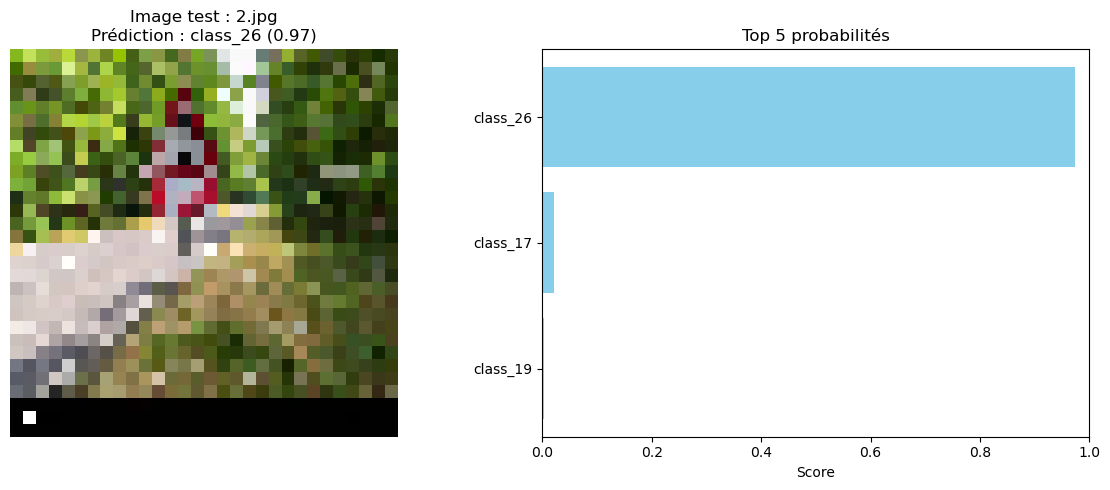


Top prédictions :
class_26             -> 0.974
class_17             -> 0.022
class_19             -> 0.002


In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# Params
IMG_PATH = "2.jpg"#chemin image test
IMG_SIZE = (X_train.shape[1],X_train.shape[2])# taille d'entrée du modèle
N_CLASSES = 43#nombre de classes du dataset

# Names des classes
class_names = [f"class_{i}" for i in range(N_CLASSES)]

# Charger et préparer l'image
img = load_img(IMG_PATH, target_size=IMG_SIZE)
x = img_to_array(img)
x = x / 255.0
x = np.expand_dims(x, axis=0)# (1, H, W, 3)

# Prédiction
preds = model_v4.predict(x)[0]
top_k = 3 # top 3 classes les plus probables
top_idx = np.argsort(preds)[-top_k:][::-1]

# affichage
plt.figure(figsize=(12,5))

# Image
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis("off")
best_class = class_names[top_idx[0]]
best_proba = preds[top_idx[0]]
plt.title(f"Image test : {IMG_PATH}\nPrédiction : {best_class} ({best_proba:.2f})")

# Barres de probas
plt.subplot(1,2,2)
labels = [class_names[i] for i in top_idx]
values = preds[top_idx]
plt.barh(labels, values, color="skyblue")
plt.gca().invert_yaxis()
plt.xlim(0,1)
plt.title("Top 5 probabilités")
plt.xlabel("Score")
plt.tight_layout()

plt.show()

# Impression console
print("\nTop prédictions :")
for i in top_idx:
    print(f"{class_names[i]:20s} -> {preds[i]:.3f}")


134/134 [==============================] - 1s 4ms/step


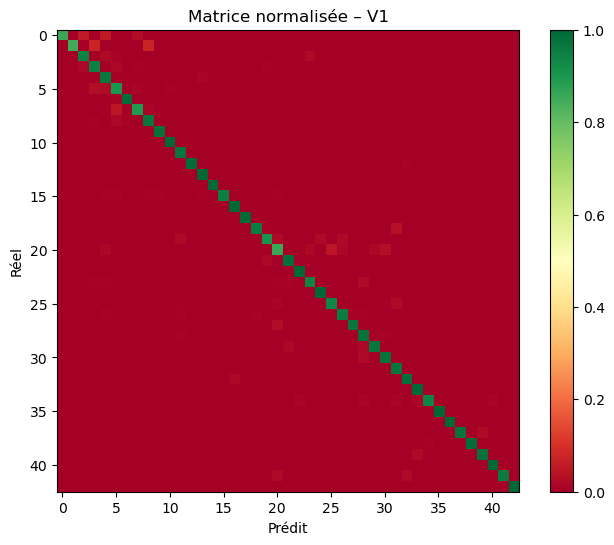

134/134 [==============================] - 1s 4ms/step


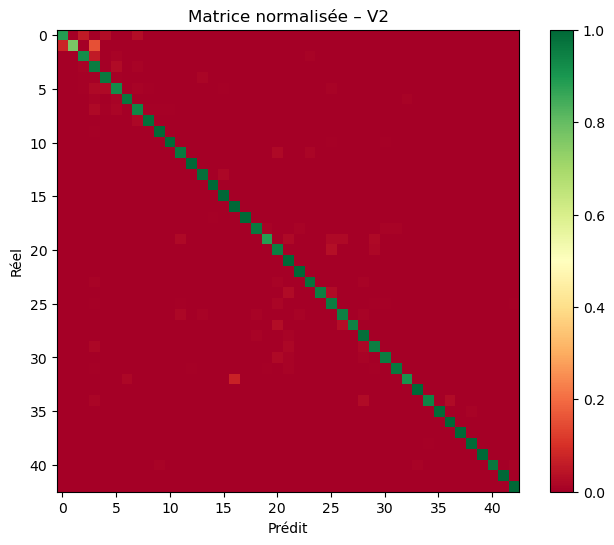

134/134 [==============================] - 1s 6ms/step


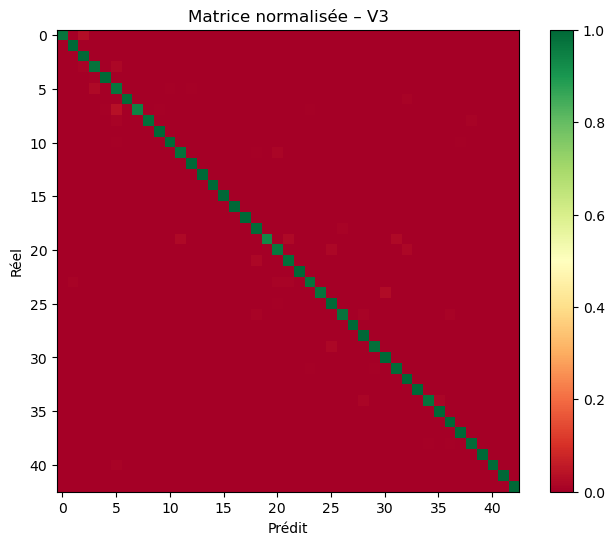

134/134 [==============================] - 1s 10ms/step


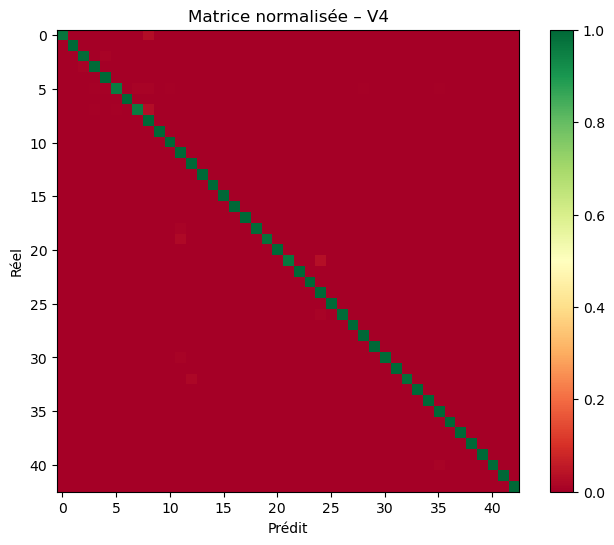

In [47]:
from sklearn.metrics import confusion_matrix


def plot_normalized_confusion_matrix(model, X_test, y_true, title):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize="true")

    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="RdYlGn", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

plot_normalized_confusion_matrix(model_v1, X_test, y_true, "Matrice normalisée – V1")
plot_normalized_confusion_matrix(model_v2, X_test, y_true, "Matrice normalisée – V2")
plot_normalized_confusion_matrix(model_v3, X_test, y_true, "Matrice normalisée – V3")
plot_normalized_confusion_matrix(model_v4, X_test, y_true, "Matrice normalisée – V4")
